# Data EDA

## global data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# initialize spark
spark = SparkSession.builder \
    .appName("News Data Analysis") \
    .config("spark.driver.extraJavaOptions", "-Xlog:disable") \
    .config("spark.executor.extraJavaOptions", "-Xlog:disable") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 18:44:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# define the schema
schema = StructType([
    StructField("timestamp", IntegerType(), True),
    StructField("source", StringType(), True),
    StructField("archive", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("probability", FloatType(), True),
    StructField("keywords", MapType(StringType(), IntegerType()), True),
    StructField("sentiment", FloatType(), True),
    #StructField("status", StringType(), True),
    #StructField("error", StringType(), True)
])

In [3]:
df01 = spark.read.format("json").schema(schema).load("data/news/status=success")
df02 = spark.read.format("json").schema(schema).load("data/news/status=error")
df03 = spark.read.format("json").schema(schema).load("data/news/status=duplicate")
df04 = spark.read.format("json").schema(schema).load("data/news/status=notnews")

print("Total number of links taken into consideration: ", df01.count() + df02.count() + df03.count() + df04.count())
print(f"Number of actually success news: {df01.count()},")
print(f"which are distributed across {len(df01.inputFiles())} files.")

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=23679Kb max_used=23688Kb free=107392Kb
 bounds [0x000000010a98c000, 0x000000010c0dc000, 0x000000011298c000]
 total_blobs=9852 nmethods=8931 adapters=836
 compilation: disabled (not enough contiguous free space left)


Total number of links taken into consideration:  3056418


Number of actually success news: 682905,
which are distributed across 4109 files.


In [4]:
df01.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- archive: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- probability: float (nullable = true)
 |-- keywords: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = true)
 |-- sentiment: float (nullable = true)



In [5]:
df01.show(5)

+---------+-------+--------------------+-------+-----------+--------------------+----------+
|timestamp| source|             archive|     id|probability|            keywords| sentiment|
+---------+-------+--------------------+-------+-----------+--------------------+----------+
|   202302|Público|https://arquivo.p...|2998907| 0.54230416|{Pearl Jam -> 1, ...|0.65978855|
|   202302|    RTP|https://arquivo.p...|3002030| 0.54930234|{ÁREAS -> 2, cida...| 0.6770514|
|   202302|    RTP|https://arquivo.p...|2998531|  0.6112756|{função -> 2, can...| 0.6864225|
|   202302|    RTP|https://arquivo.p...|2998750|  0.5712072|{Op -> 1, cancela...|0.66953796|
|   202302|    RTP|https://arquivo.p...|2999652|  0.5997843|{gigante -> 2, co...|-0.5735483|
+---------+-------+--------------------+-------+-----------+--------------------+----------+
only showing top 5 rows



In [6]:
spark.stop()
%reset -f

## good (preprocessed) data

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# initialize spark
spark = SparkSession.builder \
    .appName("News Data Analysis") \
    .config("spark.driver.extraJavaOptions", "-Xlog:disable") \
    .config("spark.executor.extraJavaOptions", "-Xlog:disable") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [8]:
df = spark.read.parquet("data/news_processed")

In [9]:
df.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- archive: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- probability: float (nullable = true)
 |-- keywords: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = true)
 |-- sentiment: double (nullable = true)
 |-- significant_keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [10]:
print("Total number of news: ", df.count())
print("First date in the dataset: ", df.select("timestamp").orderBy("timestamp").first()[0])
print("Last date in the dataset: ", df.select("timestamp").orderBy(df.timestamp.desc()).first()[0])
print("Number of unique sources: ", df.select("source").distinct().count())
print("Number of unique keywords:", df.select(F.explode("keywords").alias("k", "v")).select("k").distinct().count())

Total number of news:  349519
First date in the dataset:  199801
Last date in the dataset:  202411
Number of unique sources:  20


Number of unique keywords: 1324793


In [11]:
df.show(5)

+---------+-------------+--------------------+-------+-----------+--------------------+------------------+--------------------+
|timestamp|       source|             archive|     id|probability|            keywords|         sentiment|significant_keywords|
+---------+-------------+--------------------+-------+-----------+--------------------+------------------+--------------------+
|   201911|Dinheiro Vivo|https://arquivo.p...|1735823|   0.649114|{Rendimento -> 4,...|0.4046257495880127|[portugal, euro, ...|
|   201902|Dinheiro Vivo|https://arquivo.p...|1371223| 0.52495015|{Só -> 1, Estrutu...|0.6423046350479126|    [tesla, bateria]|
|   201712|Dinheiro Vivo|https://arquivo.p...| 779690| 0.62055546|{CTT -> 1, smartp...|0.2865161657333374|[canal, televisao...|
|   202003|      Público|https://arquivo.p...|2030825| 0.66034263|{Diagnóstico -> 2...|0.7486852169036865|[perito, vinho, i...|
|   202102|          RTP|https://arquivo.p...|2349281| 0.57806003|{PP -> 1, Popular...|0.734032011032104

## filtering query / specific keyword

[OLD] benchmarking the performance of the query

with cache

```
Galp: 18.44
galp: 13.70
Millenium: 16.94
```

without cache

```
Millenium: > 31
```

In [12]:
query = "galp"

import re
import unicodedata

def standardize_keyword(texto):
    texto = texto.lower()
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    texto = re.sub(r'[^a-z0-9\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

In [13]:
# find the query in the df and keep those news
df_with_query = df.filter(F.array_contains(df["significant_keywords"], standardize_keyword(query)))

print(f"Number of news with the query: {df_with_query.count()}")

df_with_query.show(5)

Number of news with the query: 1277
+---------+-------------+--------------------+-------+-----------+--------------------+--------------------+--------------------+
|timestamp|       source|             archive|     id|probability|            keywords|           sentiment|significant_keywords|
+---------+-------------+--------------------+-------+-----------+--------------------+--------------------+--------------------+
|   201804|Dinheiro Vivo|https://arquivo.p...| 953443|  0.7109523|{Hoje -> 1, Meta ...|  0.5895840287208557|[trimestre, aumen...|
|   201905|     Expresso|https://arquivo.p...|1509735| 0.57049173|{Empresa -> 2, re...|-0.46501868963241577|[viagem, assuntos...|
|   202007|         SAPO|https://arquivo.p...|2180320|   0.533329|{Ramalho -> 2, Em...|  0.6600978136062622|[empresa, ventila...|
|   202009|     Expresso|https://arquivo.p...|2233209| 0.78600085|{Refinação -> 2, ...|  0.6525238513946533|[empresa, refinar...|
|   201804|         SAPO|https://arquivo.p...| 973186|

In [14]:
# create key value pairs for each seen keyword
result = df_with_query.rdd.flatMap(lambda row: [
    (key, (
        value if value is not None else 0,
        {row["timestamp"]: value if value is not None else 0},
        (row["sentiment"] or 0.0) * (value if value is not None else 0),
        {row["source"]: 1},
        [row["archive"]] if row["archive"] is not None else []
    )) for key, value in (row["keywords"] or {}).items()
])

# reduce by key to combine the values
result = result.reduceByKey(lambda a, b: (
    a[0] + b[0],  # sum counts
    {ts: a[1].get(ts, 0) + b[1].get(ts, 0) for ts in set(a[1]) | set(b[1])},  # merge timestamp dictionaries
    a[2] + b[2],  # sum sentiments
    {source: a[3].get(source, 0) + b[3].get(source, 0) for source in set(a[3]) | set(b[3])},  # merge source dictionaries
    a[4] + b[4]  # concatenate news lists
))

# remove where key is same as standardized keyword
result = result.filter(lambda x: standardize_keyword(x[0]) != standardize_keyword(query))

# divide sentiment by count to get average sentiment
result = result.mapValues(lambda x: (
    x[0],
    x[1],
    x[2] / x[0] if x[0] > 0 else 0,
    x[3],
    x[4]
))

### info

In [15]:
print(f"Number of news with the query: {df_with_query.count()}")
print(f"First date in the dataset: {df_with_query.select('timestamp').orderBy('timestamp').first()[0]}")
print(f"Number of unique keywords with the query: {result.count()}")

Number of news with the query: 1277
First date in the dataset: 200502


Number of unique keywords with the query: 31788


### graph

input : *K* top words json

In [16]:
K = 5

top_n = (
    result.sortBy(lambda x: x[1][0], ascending=False)
          .take(K)
)

input = dict(top_n)

# use graph.py

### sources pie

df_with_query -> sources and count

In [17]:
from pyspark.sql import functions as F
import plotly.graph_objects as go

# Group by the column and count the values
value_counts_df = df_with_query.groupBy('source').count().toPandas()

# Extract labels and values directly
labels = value_counts_df['source']
values = value_counts_df['count']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hoverinfo='label+value+percent',
    hovertemplate="<b>%{label}</b><br>Notícias: %{value}<br>Percentagem: %{percent:.2%}<extra></extra>"
)])

fig.update_traces(
    textposition='inside',
    textinfo='label',
    textfont_size=12
)

fig.update_layout(
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=25, b=25, l=0, r=0)
)

fig.show(
    config={'displayModeBar': False}
)

### topic ts

df_with_query -> timestamp, count, keywords

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list
import pandas as pd
import plotly.express as px

traducao_meses = {
    "January": "Janeiro", "February": "Fevereiro", "March": "Março",
    "April": "Abril", "May": "Maio", "June": "Junho",
    "July": "Julho", "August": "Agosto", "September": "Setembro",
    "October": "Outubro", "November": "Novembro", "December": "Dezembro"
}

news_by_month = (
    df_with_query
    .groupBy('timestamp')
    .agg(F.count('archive').alias('count_of_news'))
    .toPandas()
)

keywords_by_month = (
    df_with_query
    .select('*', F.explode('keywords'))
    .groupBy("timestamp", "key")
    .agg(F.sum("value").alias("key_mentions"))
    .filter(F.col("key") != query)
    .withColumn("rank", F.row_number().over(Window.partitionBy("timestamp").orderBy(F.desc("key_mentions"))))
    .filter(F.col("rank") <= 5)
    .groupBy("timestamp")
    .agg(collect_list("key").alias("top5_keywords"))
    .toPandas()
)

news_history = news_by_month.merge(keywords_by_month, on="timestamp", how="inner")
news_history["timestamp"] = pd.to_datetime(news_history["timestamp"].astype(str), format='%Y%m')

min_date = news_history["timestamp"].min()
max_date = news_history["timestamp"].max()
full_range = pd.date_range(start=min_date, end=max_date, freq='MS')

news_history = news_history.set_index("timestamp").reindex(full_range).fillna(0).reset_index()
news_history = news_history.rename(columns={"index": "timestamp"})
news_history = news_history.sort_values(by="timestamp")

news_history["data_formatada"] = news_history["timestamp"].dt.strftime("%B de %Y").replace(traducao_meses, regex=True)
news_history["top5_keywords"] = news_history["top5_keywords"].apply(
    lambda words: "-" if words == 0 else "<br>".join([f"{i+1}. {word}" for i, word in enumerate(words)])
)

# Create Plotly figure
fig = px.line(
    news_history,
    x="timestamp",
    y="count_of_news",
    line_shape="linear",
    custom_data=news_history[["data_formatada", "top5_keywords"]],
)

fig.update_traces(
    hovertemplate="<b>Data:</b> %{customdata[0]}<br>"
                  "<b>📊 Notícias:</b> %{y}<br>"
                  "<b>Top 5 Tópicos:</b><br>%{customdata[1]}"
)

fig.update_layout(
    xaxis_title="Data",
    yaxis_title="Quantidade de Notícias",
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(t=0, b=0, l=0, r=0),
    xaxis=dict(
        showgrid=False,
        zeroline=True,
        zerolinecolor="black",
        linecolor="black",
        linewidth=2
    ),
    yaxis=dict(
        range=[0, max(news_history["count_of_news"])*1.1],
        showgrid=True,  
        gridcolor="lightgray",  
        zeroline=True,
        zerolinecolor="black",
        linecolor="black",
        linewidth=2
    ),
)

fig.update_traces(line=dict(color='rgb(101, 110, 242)'),
                    hoverlabel=dict(bgcolor='rgb(101, 110, 242)',
                                    bordercolor='rgb(101, 110, 242)',
                                    font=dict(color='white')))

fig.update_xaxes(tickformat="%Y-%m")

# Show figure
fig.show()

### topic wcloud

word counts: *key: count*

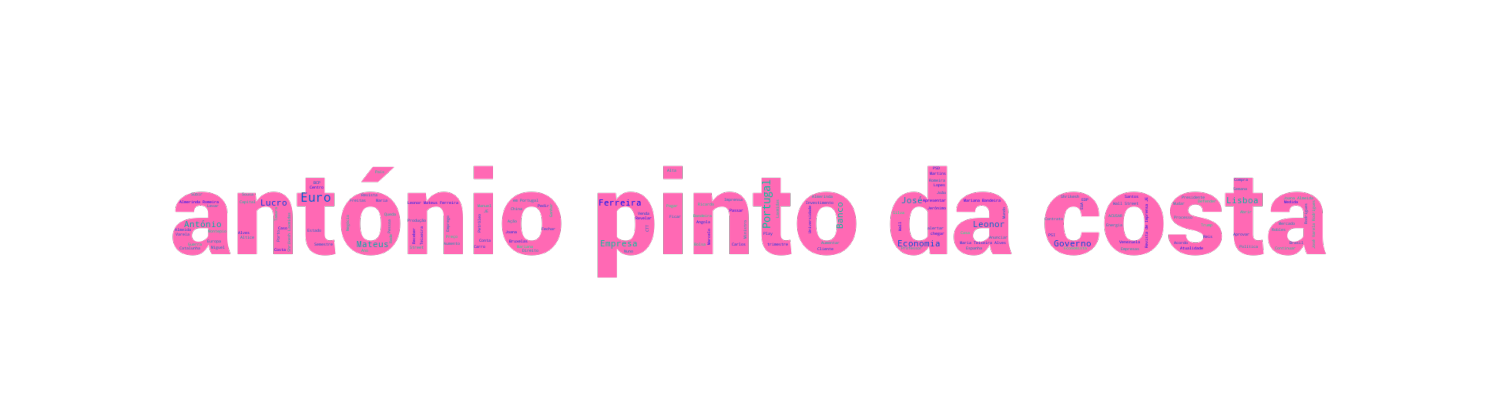

In [19]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_counts = dict(
    result.map(lambda x: (x[0], x[1][0]))
          .collect()
)

# Constants
IMAGE_SIZE = (1920, 500)  # Fixed background size (canvas)
TEXT = "antónio pinto da costa"
FONT_PATH = "/Users/hugover/Desktop/IM_assetsGH/Roboto-Black.ttf"
MAX_FONT_SIZE = 500  # Max possible font size

# Load font
font = ImageFont.truetype(FONT_PATH, size=MAX_FONT_SIZE)

def get_optimal_font_size(text, font_path, max_size, image_size):
    """Determine the best font size to fit within the image."""
    for size in range(max_size, 5, -5):  # Step down in increments
        font = ImageFont.truetype(font_path, size=size)
        temp_img = Image.new("RGBA", image_size, (0, 0, 0, 0))
        draw = ImageDraw.Draw(temp_img)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        if text_width <= image_size[0] * 0.8 and text_height <= image_size[1] * 1:  
            return font, bbox  # Fit within 80% width & 50% height

    return font, bbox  # Return the smallest size if no fit

# Get optimal font size
font, bbox = get_optimal_font_size(TEXT, FONT_PATH, MAX_FONT_SIZE, IMAGE_SIZE)

# Calculate centered position
text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
x_offset = (IMAGE_SIZE[0] - text_width) // 2
y_offset = (IMAGE_SIZE[1] - text_height) // 2

# Create fixed-size image (1920x1080)
final_img = Image.new("RGBA", IMAGE_SIZE, (0, 0, 0, 0))
draw = ImageDraw.Draw(final_img)

# Draw centered text
draw.text((x_offset, y_offset), TEXT, fill=(255, 105, 180), font=font)  # Pink text

# Generate mask for WordCloud (ensure proper alpha channel handling)
mask = np.array(final_img.convert("L"))  # Convert to grayscale to use as a mask

# Generate WordCloud
wc = WordCloud(
    width=IMAGE_SIZE[0], height=IMAGE_SIZE[1],
    background_color=None, min_font_size=5, mode="RGBA",
    colormap="winter", mask=~mask, contour_color="black"
).generate_from_frequencies(word_counts)

# Convert WordCloud to image
wc_image = wc.to_image()

# Merge word cloud and text
final_img = Image.alpha_composite(final_img, wc_image)

# Show final image
plt.figure(figsize=(IMAGE_SIZE[0] / 100, IMAGE_SIZE[1] / 100))  # Adjust figure size
plt.imshow(final_img)
plt.axis("off")  # Hide axes
plt.show()

### related info

json

In [20]:
search_topic = "EDP"
filtered = dict(result.filter(lambda x: x[0] == search_topic).collect())[search_topic]

print(f"Number of news where both {query} and {search_topic} are mentioned: {filtered[0]}")

Number of news where both galp and EDP are mentioned: 2643


### related sentiment

json

In [21]:
filtered[2]

0.3776307443461994

### related ts

json

In [22]:
from pyspark.sql import functions as F
import pandas as pd
import plotly.graph_objects as go

query = "Galp"
search_topic = "EDP"

#traducao_meses = {
#    "January": "Janeiro", "February": "Fevereiro", "March": "Março",
#    "April": "Abril", "May": "Maio", "June": "Junho",
#    "July": "Julho", "August": "Agosto", "September": "Setembro",
#    "October": "Outubro", "November": "Novembro", "December": "Dezembro"
#}

# number of news per month
news_by_month = (
    df_with_query
    .groupBy('timestamp')
    .agg(F.count('archive').alias('count_of_news'))
    .toPandas()
)
news_by_month["timestamp"] = pd.to_datetime(news_by_month["timestamp"].astype(str), format='%Y%m')

# number of mentions of the specific keyword
specific_keyword = pd.DataFrame(list(filtered[1].items()), columns=["date", "count_specific_keyword"])
specific_keyword["date"] = pd.to_datetime(specific_keyword["date"], format="%Y%m")

# merge the two dataframes
news_history = news_by_month.merge(specific_keyword, left_on="timestamp", right_on="date", how="left")

# create full data range
min_date = news_history["timestamp"].min()
max_date = news_history["timestamp"].max()
full_range = pd.date_range(start=min_date, end=max_date, freq='MS')
news_history = news_history.set_index("timestamp").reindex(full_range).fillna(0).reset_index()
news_history = news_history.rename(columns={"index": "timestamp"})
news_history = news_history.sort_values(by="timestamp")

#news_history["data_formatada"] = news_history["timestamp"].dt.strftime("%B de %Y").replace(traducao_meses, regex=True)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=news_history["timestamp"],
    y=news_history["count_of_news"],
    mode="lines",
    name=f"Notícias sobre {query}",
    hovertemplate="%{y}"
))

fig.add_trace(go.Scatter(
    x=news_history["timestamp"],
    y=news_history["count_specific_keyword"],
    mode="lines",
    name=f"Menções de {search_topic} em notícias sobre {query}",
    hovertemplate="%{y}"
))

fig.update_layout(
    xaxis_title="Data",
    yaxis_title="Contagem",
    hovermode="x unified",
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(t=0, b=0, l=0, r=0),
    xaxis=dict(
        showgrid=False,
        zeroline=True,
        zerolinecolor="black",
        linecolor="black",
        linewidth=2
    ),
    yaxis=dict(
        range=[0, max(news_history["count_of_news"].max(), news_history["count_specific_keyword"].max()) * 1.1],
        showgrid=True,  
        gridcolor="lightgray",  
        zeroline=True,
        zerolinecolor="black",
        linecolor="black",
        linewidth=2
    ),
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor="rgba(255,255,255,1)",
        bordercolor="black",
        borderwidth=1
    ),
)

fig.data[0].update(line=dict(color='rgba(101, 110, 242, 0.3)'))
fig.data[1].update(line=dict(color='rgb(101, 110, 242)'))

fig.update_xaxes(tickformat="%m/%Y")

fig.show(config={'displayModeBar': False})

### related pie

json

In [23]:
import plotly.graph_objects as go

# Group by the column and count the values
sources = filtered[3]

# Extract labels and values directly
labels = list(sources.keys())
values = list(sources.values())

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hoverinfo='label+value+percent',
    hovertemplate="<b>%{label}</b><br>Notícias: %{value}<br>Percentagem: %{percent:.2%}<extra></extra>"
)])

fig.update_traces(
    textposition='inside',
    textinfo='label',
    textfont_size=12
)

fig.update_layout(
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=25, b=25, l=0, r=0)
)

fig.show(
    config={'displayModeBar': False}
)

### related news

json

In [24]:
import re

def news_topicrelation(json_searchtopic_data):

    company_logos = [
        'record.png',
        'noticiasaominuto.png',
        'lusa.png',
        'jornaldenegocios.png',
        'tsf.png',
        'sicnoticias.png',
        'expresso.png',
        'publico.png',
        'dn.png',
        'observador.png',
        'sapo.png',
        'iol.png',
        'rtp.png',
        'cnn.png',
        'cmjornal.png',
        'jn.png',
        'nit.png',
        'dinheirovivo.png',
        'aeiou.png',
    ]

    divs = {}
    titles = set()

    for url in json_searchtopic_data:
        link_content = url.split("/")

        # set title
        title = link_content[-1] if link_content[-1] != "" else link_content[-2]
        title = title.split("?")[0].split("_")[0]
        title = re.sub(r'^\d{4}-\d{2}-\d{2}-', '', title)
        title = title.lower() if "-" in title else "Sem título disponível..."

        # check if title is repeated
        if title not in titles:
            titles.add(title)
        else:
            continue

        # set date
        date = link_content[5]
        date = f"{date[:4]}-{date[4:6]}-{date[6:8]}"

        # set source
        company = link_content[8].replace("www.", "")

        # get source logo if exists
        is_there_a_logo = False
        for img in company_logos:
            if img[:-4] in company:
                img = f"0news_logos/{img}"
                is_there_a_logo = True
                break
        if not is_there_a_logo:
            img = "0news_logos/404.png"

        # create the div
        div = f"""
                            <div class="testimonial-item bg-transparent border rounded text-white p-4">
                                <i class="fa fa-quote-left fa-2x mb-3"></i>
                                <a href="{url}" target="_blank" rel="noopener noreferrer" class="d-block text-decoration-none mb-3" style="color: inherit; height: 4.5em;">
                                    <p style="margin: 0; text-overflow: ellipsis; overflow: hidden; display: -webkit-box; -webkit-line-clamp: 3; -webkit-box-orient: vertical; height: 100%;">{title}</p>
                                </a>
                                <div class="d-flex align-items-center">
                                    <img class="img-fluid flex-shrink-0 rounded-circle" src="{img}" style="width: 50px; height: 50px;">
                                    <div class="ps-3">
                                        <h6 class="text-white mb-1">
                                            {company} 
                                            <a href="{url}" target="_blank" rel="noopener noreferrer" style="margin-left: 5px;">
                                                <i class="bi bi-box-arrow-up-right"></i>
                                            </a>
                                        </h6>
                                        <small>{date[:-3]}</small>
                                    </div>
                                </div>
                            </div>
        """

        # save the div
        if date in divs:
            divs[date].append(div)
        else:
            divs[date] = [div]

    # sort the divs by date and prepare for output
    divs = dict(sorted(divs.items(), key=lambda item: item[0], reverse=False))
    divs = "\n".join([div for divs_list in divs.values() for div in divs_list])

    return divs, len(titles)



# get the divs and the number of news
divs, num_news = news_topicrelation(filtered[4])

# read and replace "{{ atchim }}" with divs
#with open("0info_urls.html", "r") as f:
#    content = f.read()

#content = content.replace("{{ atchim }}", divs)

# write the new content
#with open("0.html", "w") as f:
#    f.write(content)